In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid , save_image
# from boltzman_pytorch import *
from tqdm.notebook import tqdm
import os
%matplotlib inline

In [7]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
    
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

rbm_mnist = RBM(k=1)
train_op = optim.SGD(rbm_mnist.parameters(),0.1)


path_mnist = "./saved_models/rbm_mnist_numbers.pth"
if os.path.exists(path_mnist):
    rbm_mnist.load_state_dict(torch.load(path_mnist))
    print("RBM model found")


for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm_mnist(sample_data)
        loss = rbm_mnist.free_energy(v) - rbm_mnist.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    
torch.save(rbm_mnist.state_dict(), path_mnist)

RBM model found


/media/imsanskar/My_files/Projects/Minor/env/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training loss for 0 epoch: -0.13336679339408875
Training loss for 1 epoch: -0.057078249752521515
Training loss for 2 epoch: 0.11860432475805283
Training loss for 3 epoch: 0.24018384516239166
Training loss for 4 epoch: 0.2919023036956787
Training loss for 5 epoch: 0.3421306014060974
Training loss for 6 epoch: 0.40364667773246765
Training loss for 7 epoch: 0.46622565388679504
Training loss for 8 epoch: 0.5864583253860474
Training loss for 9 epoch: 0.6005963683128357


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RBM(k = 1)
loss_fn = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
loss_fn.to(device)
model.to(device)
print(device)

cuda


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Grayscale()
])
handwritten_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Train/", transform)
test_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Test/", transform)
batch_size = 512
dataloader = torch.utils.data.DataLoader(dataset=handwritten_data, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size = 4, shuffle = True)

In [12]:
import os
rbm = RBM(784, 500, k = 1)
loss_fn = nn.L1Loss()
optimizer = optim.SGD(rbm.parameters(), lr = 0.1)
# rbm.to(device)
path = "./saved_models/rbm_nepali_characters.pth"
if os.path.exists(path):
#     rbm.load_state_dict(torch.load(path))
    print("RBM model found")

RBM model found


In [ ]:
loss_boltzman = np.array([])
for epoch in range(100):
    loss_ = []
    for i, (data,target) in tqdm(enumerate(dataloader)):
        data = Variable(data.view((-1 ,784)))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = loss_fn(rbm.free_energy(v), rbm.free_energy(v1))
#         loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
            
    print(f"Total Data = {i}")
            
    loss_boltzman = np.append(loss_boltzman, np.mean(loss_))
    with open("loss.csv", 'a') as f:
        f.write(f"Loss, {np.mean(loss_):4f}\n")

0it [00:00, ?it/s]

Training loss for 0 epoch: 1.2983665466308594
Training loss for 0 epoch: 1.3327977657318115
Total Data = 152


0it [00:00, ?it/s]

Training loss for 1 epoch: 0.3275032043457031
Training loss for 1 epoch: 1.2775014638900757
Total Data = 152


0it [00:00, ?it/s]

Training loss for 2 epoch: 0.2294178009033203
Training loss for 2 epoch: 1.4102030992507935
Total Data = 152


0it [00:00, ?it/s]

Training loss for 3 epoch: 1.6608161926269531
Training loss for 3 epoch: 1.3378022909164429
Total Data = 152


0it [00:00, ?it/s]

Training loss for 4 epoch: 1.0532646179199219
Training loss for 4 epoch: 1.268917441368103
Total Data = 152


0it [00:00, ?it/s]

Training loss for 5 epoch: 0.21120834350585938
Training loss for 5 epoch: 1.3424146175384521
Total Data = 152


0it [00:00, ?it/s]

Training loss for 6 epoch: 1.0897331237792969
Training loss for 6 epoch: 1.2440259456634521
Total Data = 152


0it [00:00, ?it/s]

Training loss for 7 epoch: 1.4898319244384766
Training loss for 7 epoch: 1.2282016277313232
Total Data = 152


0it [00:00, ?it/s]

Training loss for 8 epoch: 1.1719989776611328


In [8]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

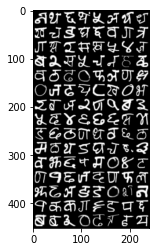

In [18]:
show_adn_save("real",make_grid(data.view(data.size()[0],1,28,28).data))

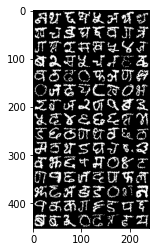

In [19]:
show_adn_save("real",make_grid(v.view(v1.size()[0],1,28,28).data))

In [22]:
torch.save(rbm.state_dict(), "saved_models/rbm_nepali_characters.pth")

## Checking Outputs

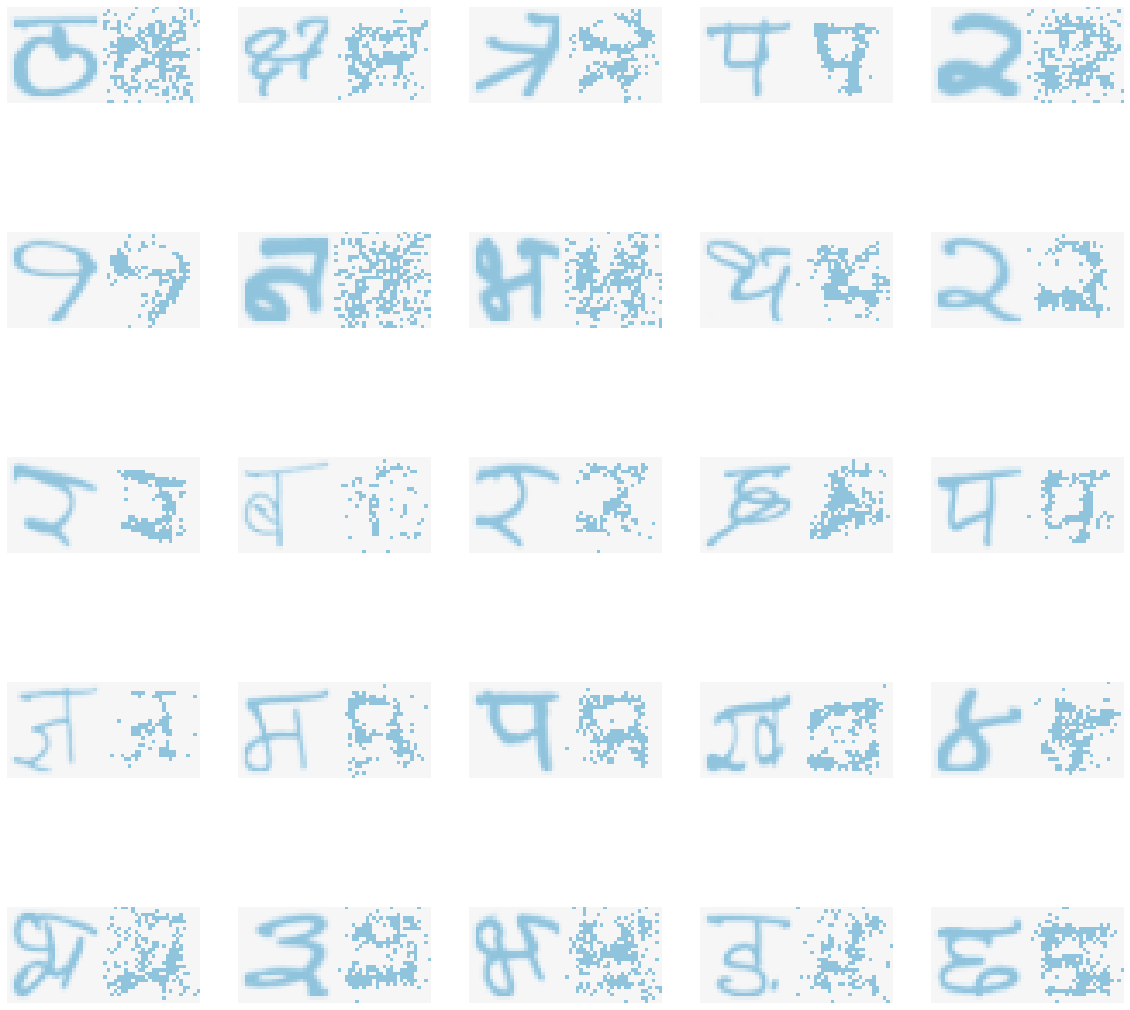

In [25]:
plt.figure(figsize=(20, 20))

for i, (data, target) in enumerate(dataloader):
    plt.subplot(5, 5, i + 1)
    
    image_width = 15
    image_height = 15
    image_transform = transforms.Compose([
#         transforms.Resize((image_width, image_height))
    ])
    image_1 = data[0].view((28, 28))
    image_2 = rbm_mnist.forward(data[0].view(784))[1].view((28, 28))
#     print(f"{image_1.shape}, {image_2.shape}")
    image_show = torch.cat(
        (image_1, image_2),
        1
    )
#     plt.imshow(data[0].view(28, 28).detach().cpu().numpy(), cmap=plt.cm.RdBu,
#                interpolation='nearest', vmin=-2.5, vmax=2.5)
#     plt.subplot(10, 20, i + 1)
#     plt.imshow(rbm.forward(data[0].view(784))[0].view((28, 28)).detach().cpu().numpy(), cmap=plt.cm.RdBu,
#                interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.imshow(image_show.detach().cpu().numpy(), cmap=plt.cm.RdBu,
               interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.axis('off')
    
    if i >= 24:
        break
plt.show()